<h1><center>Deep Learning Helping Navigate Robots</center></h1>
<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/13242/logos/thumb76_76.png?t=2019-03-12-23-33-31" width="300"></img>

### Dependencies

In [1]:
import warnings
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
cufflinks.go_offline(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

print('Train features shape', train.shape)
display(train.head())
print('Train labels shape', labels.shape)
display(labels.head())
print('Test shape', test.shape)
display(test.head())

Train features shape (487680, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


Train labels shape (3810, 3)


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Test shape (488448, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


### Join train features with labels

In [3]:
train = train.join(labels, on='series_id', rsuffix='_')
train.drop('series_id_', axis=1, inplace=True)
print(train.shape)
display(train.head())

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


### Plotly graphs may take a while to load.

# EDA

## Surface distribution
- Let's see what's the label distribution of our data

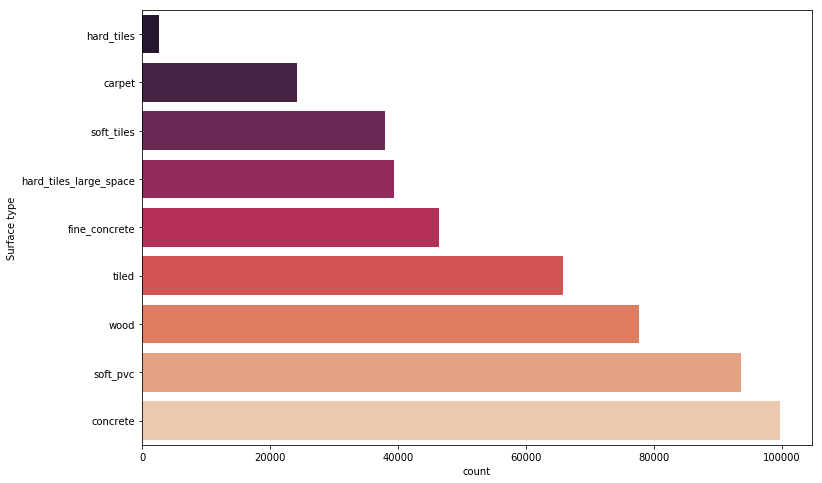

In [4]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(y='surface', data=train, palette="rocket", order=reversed(train['surface'].value_counts().index))
ax.set_ylabel("Surface type")
plt.show()

### Surface distribution by "group_id"

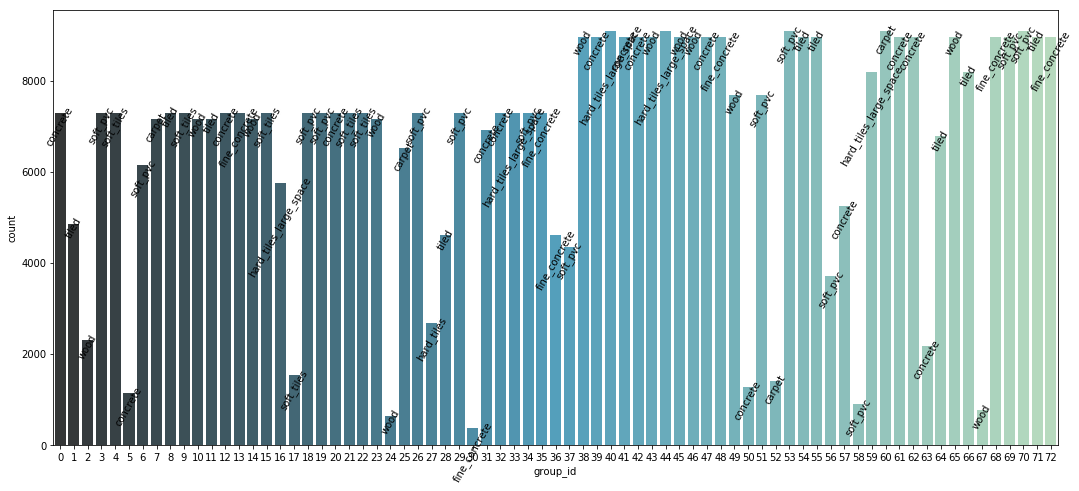

In [5]:
group_df = train.groupby(['group_id', 'surface'])['surface'].agg({'surface':['count']}).reset_index()
group_df.columns = ['group_id', 'surface', 'count']
f, ax = plt.subplots(figsize=(18, 8))
ax = sns.barplot(x="group_id", y="count", data=group_df, palette="GnBu_d")

for index, row in group_df.iterrows():
    ax.text(row.name, row['count'], row['surface'], color='black', ha="center", rotation=60)
    
plt.show()

## Features distribution
- Now would be a good idea to see how each other type of features behavior

### Orientation distribution

In [ ]:
orientation_features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W']
train[orientation_features].iplot(kind='histogram', bins=200, subplots=True, shape=(len(orientation_features), 1))
train[orientation_features].iplot(kind='histogram', barmode='overlay', bins=200)
train[orientation_features].iplot(kind='box')

The interesting part here is that "orientation_Y" and "orientation_X" are far more spread than the other two.

### Angular velocity distribution

In [ ]:
velocity_features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']
train[velocity_features].iplot(kind='histogram', bins=200, subplots=True, shape=(len(velocity_features), 1))
train[velocity_features].iplot(kind='histogram', barmode='overlay', bins=200)
train[velocity_features].iplot(kind='box')

Here all the angular velocity features seem to be centered around 0, but "angular_velocity_Y" is less spread than the others.

### Linear acceleration distribution

In [ ]:
acceleration_features = ['linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']
train[acceleration_features].iplot(kind='histogram', bins=200, subplots=True, shape=(len(acceleration_features), 1))
train[acceleration_features].iplot(kind='histogram', barmode='overlay', bins=200)
train[acceleration_features].iplot(kind='box')

The linear acceleration features seem to be the most different between itself, all 3 features have different mean and spread.

### Preprocess the labels

In [6]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [7]:
features = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 
            'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.head())

Train shape (390144, 10)
Validation shape (97536, 10)


,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
174517,-0.22351,0.96262,0.147250,-0.041492,-0.023037,0.107670,-0.313830,0.016821,3.8752,-11.1430
434895,-0.54943,-0.82225,-0.127320,-0.076376,0.356350,-0.165830,0.212980,1.202700,11.1940,-7.9759
385247,0.78303,0.60372,0.097223,0.113750,0.064847,0.148310,-0.374690,-0.033998,2.8156,-10.2200
374689,0.92600,0.34640,0.059994,0.137600,0.096735,-0.049043,0.144260,-0.457680,3.9749,-5.1218
297812,-0.66945,-0.72716,-0.115300,-0.098892,0.215470,-0.010674,0.022843,1.427000,6.0013,-9.4340


### Model

In [8]:
epochs = 70
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [9]:
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(20, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 189       
Total params: 829
Trainable params: 829
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train.values, Y_train, validation_data=(X_val.values, Y_val), epochs=epochs, verbose=2)

Train on 390144 samples, validate on 97536 samples
Epoch 1/70
 - 41s - loss: 1.6330 - val_loss: 1.4563
Epoch 2/70
 - 38s - loss: 1.3321 - val_loss: 1.2441
Epoch 3/70
 - 36s - loss: 1.1980 - val_loss: 1.1487
Epoch 4/70
 - 37s - loss: 1.1159 - val_loss: 1.0756
Epoch 5/70
 - 36s - loss: 1.0512 - val_loss: 1.0256
Epoch 6/70
 - 37s - loss: 0.9879 - val_loss: 0.9491
Epoch 7/70
 - 36s - loss: 0.9499 - val_loss: 0.9411
Epoch 8/70
 - 37s - loss: 0.9286 - val_loss: 0.9152
Epoch 9/70
 - 38s - loss: 0.9113 - val_loss: 0.8973
Epoch 10/70
 - 38s - loss: 0.8956 - val_loss: 0.8878
Epoch 11/70
 - 36s - loss: 0.8822 - val_loss: 0.8704
Epoch 12/70
 - 37s - loss: 0.8688 - val_loss: 0.8666
Epoch 13/70
 - 37s - loss: 0.8557 - val_loss: 0.8451
Epoch 14/70
 - 37s - loss: 0.8427 - val_loss: 0.8238
Epoch 15/70
 - 38s - loss: 0.8323 - val_loss: 0.8206
Epoch 16/70
 - 37s - loss: 0.8221 - val_loss: 0.8077
Epoch 17/70
 - 39s - loss: 0.8150 - val_loss: 0.8090
Epoch 18/70
 - 37s - loss: 0.8066 - val_loss: 0.7924
Epoc

#### Model loss plot

In [11]:
history_pd = pd.DataFrame.from_dict(history.history)
history_pd.iplot(kind='line')

#### Model confusion matrix

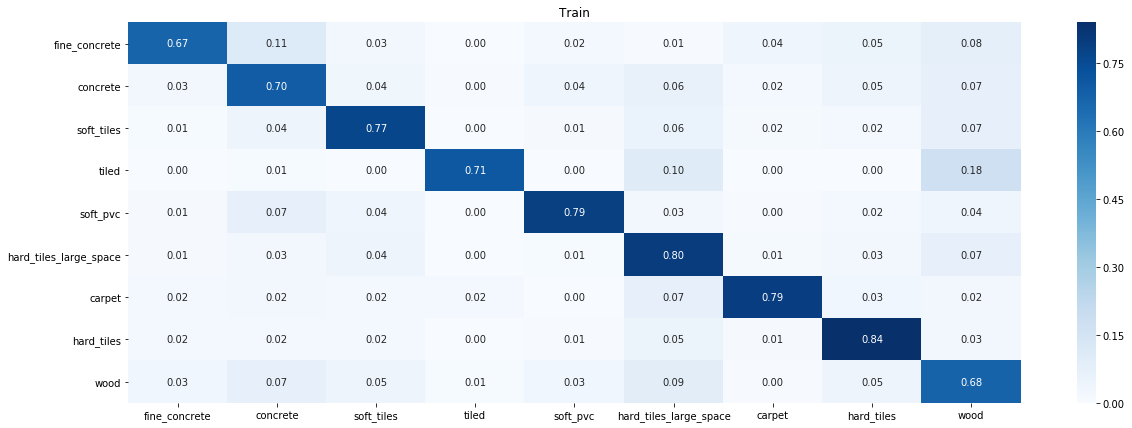

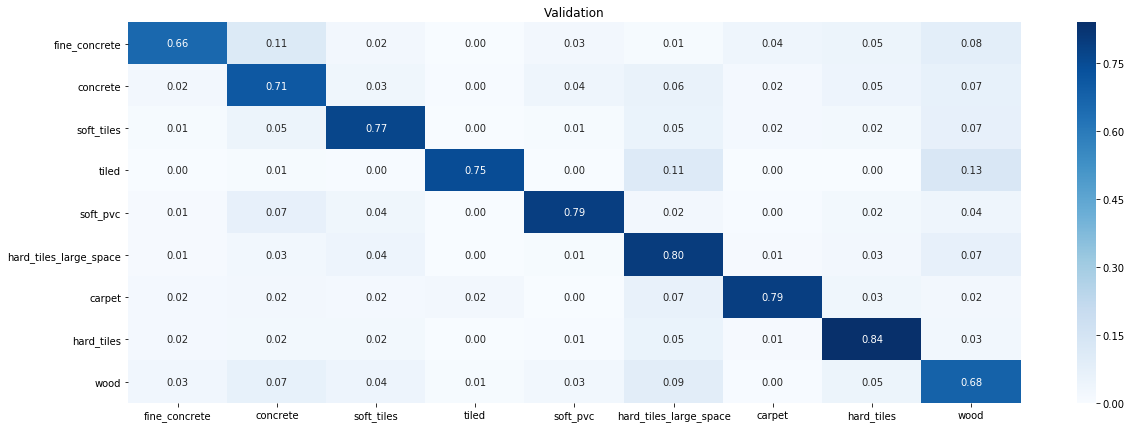

In [12]:
cnf_matrix = confusion_matrix(np.argmax(Y_train, axis=1), model.predict_classes(X_train))
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), model.predict_classes(X_val))
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [13]:
predictions = model.predict_classes(test[features].values)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)

,series_id,surface
0,0,fine_concrete
1,1,concrete
2,2,tiled
3,3,wood
4,4,soft_pvc
5,5,concrete
6,6,concrete
7,7,concrete
8,8,wood
9,9,wood
